### 1. Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import sklearn as sk

import sklearn.metrics as metrics
import os
import pickle
import itertools  

from matplotlib import rc
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import plotly.express as px
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
#import statsmodels.api as sm
from statsmodels.formula.api import ols
import random

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [4]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

In [5]:
from sklearn.metrics import matthews_corrcoef
import shap

In [6]:
# Set the global font to be DejaVu Sans, size 10 
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 2. Load pickles

In [7]:
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_bcorr.pkl', 'rb') as handle:
    prec_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prot_bcorr.pkl', 'rb') as handle:
    prot_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_2_gr.pkl', 'rb') as handle:
    prec_2_gr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/meta_prot.pkl', 'rb') as handle:
    meta_prot = pickle.load(handle)

### 3. T test on precursor train 80%

In [ ]:
# disease groups 0,1,4 => 0
# control group 2,3 => 1

In [10]:
Xtrain_prec, Xtest_prec, ytrain_prec, ytest_prec = train_test_split(prec_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 

In [11]:
Xtrain_prec_g=Xtrain_prec.merge(prec_2_gr.Group, left_index=True, right_index=True)

In [12]:
Xtrain_prec_g.shape

(161, 1469)

In [13]:
Xtrain_prec_g_melt = pd.melt(Xtrain_prec_g, id_vars=['Group'], value_vars=Xtrain_prec.columns.tolist())
Xtrain_prec_g_melt.shape

(236348, 3)

In [14]:
Xtrain_prec_g_melt=Xtrain_prec_g_melt.rename(columns={"variable": "Precursors"})

In [15]:
Xtrain_prec_g_melt['Group'] = Xtrain_prec_g_melt['Group'].astype('int')

In [16]:
pvalues=[]
i=0
for x in Xtrain_prec_g_melt['Precursors'].unique():
    tempdf = Xtrain_prec_g_melt[Xtrain_prec_g_melt.isin([x]).any(axis=1)]
    coh0=[]
    coh1=[]
    coh0.append(tempdf[(tempdf.Group==0)]['value'].tolist())
    coh1.append(tempdf[(tempdf.Group==1)]['value'].tolist())
    #print('cohort  0:', coh0)
    #print('++++++++')
    ab = itertools.chain(coh0, coh1)
    data=list(ab)
    t_val, p_val = stats.ttest_ind(*data)
    pvalues.append(p_val)
    #print('p_value:', p_val)
    #print('++++++++')
    i+=1
    if i % 100==0: 
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


#### Benjamini and Hochberg FDR

In [1]:
y=multipletests(pvals=pvalues, method="fdr_bh",returnsorted=True)

NameError: name 'multipletests' is not defined

In [147]:
y

(array([ True,  True,  True, ..., False, False, False]),
 array([5.24464104e-20, 5.24464104e-20, 5.88306304e-20, ...,
        9.90334075e-01, 9.96761580e-01, 9.96761580e-01]),
 6.8462543936220754e-06,
 6.8119891008174385e-06)

In [148]:
df1 = pd.DataFrame(y[1], columns = ['BH'])

In [149]:
pvalues.sort()

In [150]:
df2 = pd.DataFrame(pvalues,columns = ['unadj_pval'])

In [151]:
BH_unadj=pd.concat([df1, df2], axis=1)

In [152]:
BH_unadj

,BH,unadj_pval
0,5.244641e-20,3.782661e-23
1,5.244641e-20,7.145288e-23
2,5.883063e-20,1.455901e-22
3,5.883063e-20,1.603014e-22
4,8.845678e-20,4.023140e-22
...,...,...
1463,9.874522e-01,9.847616e-01
1464,9.902105e-01,9.881869e-01
1465,9.903341e-01,9.889848e-01
1466,9.967616e-01,9.964062e-01


In [154]:
#find how many pvalues are < 0.01
print(len(y[1][np.where(y[1]<0.01)])) 

792


In [47]:
T=np.where(y[1] <0.01)

In [48]:
Xtrain_prec_g_melt['Precursors'].unique()[T].shape

(792,)

In [52]:
sig_prec_bcorr=prec_bcorr[Xtrain_prec_g_melt['Precursors'].unique()[T]]

In [53]:
sig_prec_bcorr.shape

(202, 792)

### 4. T test on protein train 80%

In [58]:
Xtrain_prot, Xtest_prot, ytrain_prot, ytest_prot = train_test_split(prot_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 

In [59]:
Xtrain_prot_g=Xtrain_prot.merge(prec_2_gr.Group, left_index=True, right_index=True)

In [60]:
Xtrain_prot_g.shape

(161, 196)

In [61]:
Xtrain_prot_g_melt = pd.melt(Xtrain_prot_g, id_vars=['Group'], value_vars=Xtrain_prot.columns.tolist())
Xtrain_prot_g_melt.shape

(31395, 3)

In [62]:
Xtrain_prot_g_melt=Xtrain_prot_g_melt.rename(columns={"variable": "Proteins"})

In [63]:
Xtrain_prot_g_melt['Group'] = Xtrain_prot_g_melt['Group'].astype('int')

In [64]:
pvalues=[]
i=0
for x in Xtrain_prot_g_melt['Proteins'].unique():
    tempdf = Xtrain_prot_g_melt[Xtrain_prot_g_melt.isin([x]).any(axis=1)]
    coh0=[]
    coh1=[]
    coh0.append(tempdf[(tempdf.Group==0)]['value'].tolist())
    coh1.append(tempdf[(tempdf.Group==1)]['value'].tolist())
    #print('cohort  0:', coh0)
    #print('++++++++')
    ab = itertools.chain(coh0, coh1)
    data=list(ab)
    t_val, p_val = stats.ttest_ind(*data)
    pvalues.append(p_val)
    #print('p_value:', p_val)
    #print('++++++++')
    i+=1
    if i % 100==0: 
        print(i)

100


#### Benjamini and Hochberg FDR

In [65]:
y=multipletests(pvals=pvalues, method="fdr_bh")

In [66]:
len(y[1])

195

In [67]:
#find how many pvalues are < 0.01
print(len(y[1][np.where(y[1]<0.01)])) 

90


In [68]:
T=np.where(y[1] <0.01)

In [69]:
Xtrain_prot_g_melt['Proteins'].unique()[T].shape

(90,)

In [70]:
sig_prot_bcorr=prot_bcorr[Xtrain_prot_g_melt['Proteins'].unique()[T]]

In [71]:
sig_prot_bcorr.shape

(202, 90)

### 5. Disease vs Control

In [72]:
#hyperparameter optimization on training set
input_dict = {
    'Sig Prec': sig_prec_bcorr,
    'All Prec': prec_bcorr,
    'Sig Prot': sig_prot_bcorr,
    'All Prot': prot_bcorr}
    
#parameters
Dummy_params = {}

GB_params = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

LR_params = {
    'C':[0.01,0.1,1,10,100],
    'penalty':['l2'],
    'solver':['newton-cg'],
    'max_iter':[100,200,300]}

ET_params = {
    'bootstrap': [False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

RF_params = {
    'bootstrap': [False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}
           
KNN_params = {
    'leaf_size': [1,5,10,15,20,25,30,35,40,45,50],
    'n_neighbors': [1,5,10,15,20,25,30],
    'p': [1,2]}
    
models_dict = {
    'Dummy': DummyClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()}

params_dict = {
    'Dummy': Dummy_params,
    'GB':GB_params,
    'SVC':SVC_params,
    'LR':LR_params,
    'ET': ET_params,
    'RF': RF_params,
    'KNN': KNN_params}

#run randomsearch
all_model_dict = {}
all_F1_dict = {}
all_AUPR_dict = {}

for i in input_dict.keys():
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    temp_3 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[i], prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions = params_dict[x],
                                 scoring='f1', refit=True, cv=5, n_iter=200, random_state=42)
        clf.fit(Xtrain, ytrain)
        y_predict_proba = clf.predict_proba(Xtrain)[:,1]
        precision, recall, thresholds = precision_recall_curve(ytrain,y_predict_proba)
        print('Best AUPR:',auc(recall, precision))
        print('Best F1:',clf.best_score_)
        print('Best estimator:',clf.best_estimator_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
        temp_3[x] = auc(recall, precision)
    all_model_dict[i] = temp_1
    all_F1_dict[i] = temp_2
    all_AUPR_dict[i] = temp_3
    
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)
all_AUPR_df=pd.DataFrame.from_dict(all_AUPR_dict)

Input: Sig Prec
Dummy
Best AUPR: 0.6273291925465838
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9381372549019609
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=80,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9499019607843138
Best estimator: SVC(C=0.1, gamma=1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.9393464052287582
Best estimator: LogisticRegression(C=0.1, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.9232352941176473
Best estimator: ExtraTreesClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=20, n_estimators=500, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.9248039215686277
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.9901552801605775
Best F1: 0.9483333333333335
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=30)
Input: All Prec
Dummy
Best AUPR: 0.6273291925465838
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9394444444444445
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=50, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=80,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9393464052287582
Best estimator: SVC(C=1, gamma=0.001, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.9261111111111113
Best estimator: LogisticRegression(C=0.01, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.8966666666666667
Best estimator: ExtraTreesClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                     n_estimators=500, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.9232352941176473
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=500, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.9908072009291521
Best F1: 0.9393464052287582
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=15)
Input: Sig Prot
Dummy
Best AUPR: 0.6273291925465838
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9393464052287582
Best estimator: GradientBoostingClassifier(learning_rate=0.5, max_depth=100,
                           max_features='log2', min_samples_leaf=20,
                           min_samples_split=80, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.996014164135818
Best F1: 0.9513725490196079
Best estimator: SVC(C=1, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


Best AUPR: 1.0
Best F1: 0.9511111111111111
Best estimator: LogisticRegression(C=10, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.910873015873016
Best estimator: ExtraTreesClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=20, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.9261111111111113
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=100, max_features='log2',
                       min_samples_leaf=20, min_samples_split=20,
                       n_estimators=500, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.9928637018115181
Best F1: 0.9526797385620916
Best estimator: KNeighborsClassifier(leaf_size=1, p=1)
Input: All Prot
Dummy
Best AUPR: 0.6273291925465838
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9226694186446508
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=50, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=80,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.9542483660130721
Best estimator: SVC(C=100, gamma=0.001, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


Best AUPR: 1.0
Best F1: 0.9513725490196079
Best estimator: LogisticRegression(C=0.1, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.9079971988795519
Best estimator: ExtraTreesClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=20, n_estimators=500, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.9261111111111113
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=20, n_estimators=500, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.9855936564223793
Best F1: 0.9631372549019609
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=20)


In [73]:
all_AUPR_df

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.627329,0.627329,0.627329,0.627329
GB,1.000000,1.000000,1.000000,1.000000
SVC,1.000000,1.000000,0.996014,1.000000
LR,1.000000,1.000000,1.000000,1.000000
ET,1.000000,1.000000,1.000000,1.000000
RF,1.000000,1.000000,1.000000,1.000000
KNN,0.990155,0.990807,0.992864,0.985594


In [74]:
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)

In [75]:
all_F1_df

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.000000,0.000000,0.000000,0.000000
GB,0.938137,0.939444,0.939346,0.922669
SVC,0.949902,0.939346,0.951373,0.954248
LR,0.939346,0.926111,0.951111,0.951373
ET,0.923235,0.896667,0.910873,0.907997
RF,0.924804,0.923235,0.926111,0.926111
KNN,0.948333,0.939346,0.952680,0.963137


In [76]:
input_dict = {
    'Sig Prec': sig_prec_bcorr,
    'All Prec': prec_bcorr,
    'Sig Prot': sig_prot_bcorr,
    'All Prot': prot_bcorr}

#evaluate test set
auroc = {}
fpr = {}
tpr = {}
threshold = {}
AP = {}
f1 = {}
specificity = {}
bal_accuracy = {}
precision = {}
recall1= {}
AUPR = {}
MCC= {}
prec = {}

for x in all_model_dict.keys():
    temp1 = {}
    temp2 = {}
    temp3 = {}
    temp4 = {} 
    temp5 = {}
    temp6 = {}
    temp7 = {}
    temp8 = {}
    temp9 = {}
    temp10 = {}
    temp11 = {}
    temp12 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[x], prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
    
    for y in all_model_dict[x].keys():
        model = all_model_dict[x][y]
        ypred = model.predict(Xtest)
        probs = model.predict_proba(Xtest)
        pos_probs = probs[:, 1]
        temp1[y] = roc_auc_score(ytest, pos_probs)
        temp2[y], temp3[y], temp4[y] = roc_curve(ytest, pos_probs)
        temp5[y] = average_precision_score(ytest, ypred)
        temp6[y] = f1_score(ytest, ypred)
        temp7[y] = recall_score(ytest, ypred)
        temp8[y] = balanced_accuracy_score(ytest, ypred)
        temp9[y] = recall_score(ytest, ypred, pos_label=0)
        precision, recall, _ = precision_recall_curve(ytest, pos_probs)
        temp10[y] = auc(recall, precision)
        temp11[y] = matthews_corrcoef(ytest, ypred)
        temp12[y] = precision_score(ytest, ypred,zero_division=0)
    auroc[x] = temp1
    fpr[x] = temp2
    tpr[x] = temp3
    threshold [x] = temp4
    AP[x] = temp5
    f1[x] = temp6
    recall1[x] = temp7
    bal_accuracy[x] = temp8
    specificity[x] = temp9
    AUPR[x] = temp10
    MCC[x] = temp11
    prec[x] = temp12

In [77]:
f1=pd.DataFrame.from_dict(f1)
f1

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.000000,0.000000,0.000000,0.000000
GB,0.909091,0.869565,0.956522,0.800000
SVC,0.956522,0.909091,0.956522,0.857143
LR,0.909091,0.909091,0.956522,0.909091
ET,0.857143,0.857143,0.909091,0.909091
RF,0.857143,0.857143,0.800000,0.800000
KNN,0.956522,0.956522,0.956522,0.956522


In [78]:
AP=pd.DataFrame.from_dict(AP)
AP

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.268293,0.268293,0.268293,0.268293
GB,0.850837,0.781966,0.916667,0.719635
SVC,0.916667,0.850837,0.916667,0.785144
LR,0.850837,0.850837,0.916667,0.850837
ET,0.785144,0.785144,0.850837,0.850837
RF,0.785144,0.785144,0.719635,0.719635
KNN,0.916667,0.916667,0.916667,0.916667


In [79]:
auroc=pd.DataFrame.from_dict(auroc)
auroc

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.500000,0.500000,0.500000,0.500000
GB,0.987879,0.963636,0.993939,0.981818
SVC,0.987879,0.984848,0.981818,0.990909
LR,0.987879,0.990909,0.987879,0.987879
ET,0.993939,0.993939,0.987879,0.987879
RF,0.975758,0.990909,0.987879,0.987879
KNN,0.990909,0.993939,0.995455,0.971212


In [80]:
#recall=sensitivity
recall=pd.DataFrame.from_dict(recall1)
recall

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.000000,0.000000,0.000000,0.000000
GB,0.909091,0.909091,1.000000,0.727273
SVC,1.000000,0.909091,1.000000,0.818182
LR,0.909091,0.909091,1.000000,0.909091
ET,0.818182,0.818182,0.909091,0.909091
RF,0.818182,0.818182,0.727273,0.727273
KNN,1.000000,1.000000,1.000000,1.000000


In [81]:
specificity=pd.DataFrame.from_dict(specificity)
specificity

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,1.000000,1.000000,1.000000,1.000000
GB,0.966667,0.933333,0.966667,0.966667
SVC,0.966667,0.966667,0.966667,0.966667
LR,0.966667,0.966667,0.966667,0.966667
ET,0.966667,0.966667,0.966667,0.966667
RF,0.966667,0.966667,0.966667,0.966667
KNN,0.966667,0.966667,0.966667,0.966667


In [82]:
accuracy=pd.DataFrame.from_dict(bal_accuracy)
accuracy

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.500000,0.500000,0.500000,0.500000
GB,0.937879,0.921212,0.983333,0.846970
SVC,0.983333,0.937879,0.983333,0.892424
LR,0.937879,0.937879,0.983333,0.937879
ET,0.892424,0.892424,0.937879,0.937879
RF,0.892424,0.892424,0.846970,0.846970
KNN,0.983333,0.983333,0.983333,0.983333


In [83]:
AUPR=pd.DataFrame.from_dict(AUPR)
AUPR

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.634146,0.634146,0.634146,0.634146
GB,0.971093,0.823005,0.983402,0.954334
SVC,0.963074,0.950899,0.936829,0.973806
LR,0.963074,0.973806,0.963074,0.963074
ET,0.983402,0.983402,0.963074,0.963074
RF,0.937589,0.973806,0.963074,0.963074
KNN,0.974242,0.983402,0.988636,0.857645


In [84]:
MCC=pd.DataFrame.from_dict(MCC)
MCC

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.000000,0.000000,0.000000,0.000000
GB,0.875758,0.820348,0.941335,0.742818
SVC,0.941335,0.875758,0.941335,0.809770
LR,0.875758,0.875758,0.941335,0.875758
ET,0.809770,0.809770,0.875758,0.875758
RF,0.809770,0.809770,0.742818,0.742818
KNN,0.941335,0.941335,0.941335,0.941335


In [85]:
Precision=pd.DataFrame.from_dict(prec)
Precision

,Sig Prec,All Prec,Sig Prot,All Prot
Dummy,0.000000,0.000000,0.000000,0.000000
GB,0.909091,0.833333,0.916667,0.888889
SVC,0.916667,0.909091,0.916667,0.900000
LR,0.909091,0.909091,0.916667,0.909091
ET,0.900000,0.900000,0.909091,0.909091
RF,0.900000,0.900000,0.888889,0.888889
KNN,0.916667,0.916667,0.916667,0.916667


In [86]:
no_skill = len(ytest[ytest==1]) / len(ytest)
no_skill

0.2682926829268293

In [87]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [88]:
prec_2_gr.Group.value_counts()

0    150
1     52
Name: Group, dtype: int64

In [89]:
ytest.value_counts()

0    30
1    11
Name: Group, dtype: int64

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

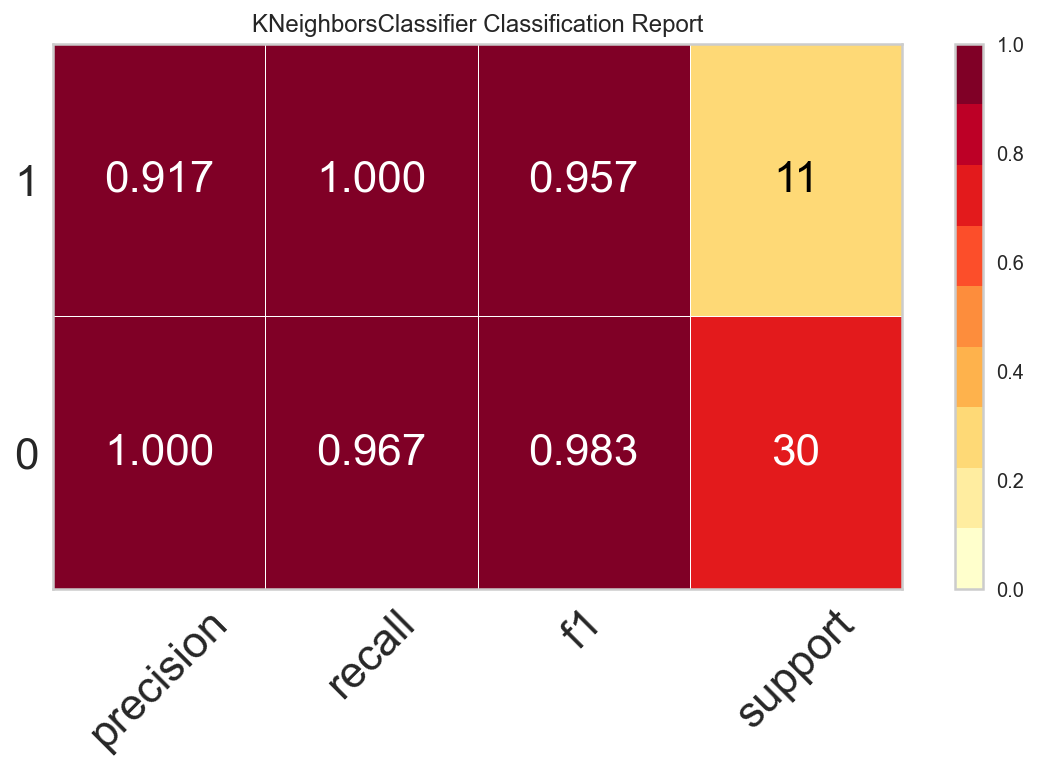

In [90]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy

Xtrain, Xtest, ytrain, ytest = train_test_split(prot_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
classes = [0,1]
model=all_model_dict['All Prot']['KNN']
visualizer=ClassificationReport(model, classes=classes, support=True)

visualizer.fit(Xtrain, ytrain)        # Fit the visualizer and the model
visualizer.score(Xtest, ytest)        # Evaluate the model on the test data
for label in visualizer.ax.texts:
    label.set_size(22)
visualizer.ax.tick_params(labelsize=22)  # change size of tick labels
visualizer.show(outpath="Fig2B_v2.svg")  

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

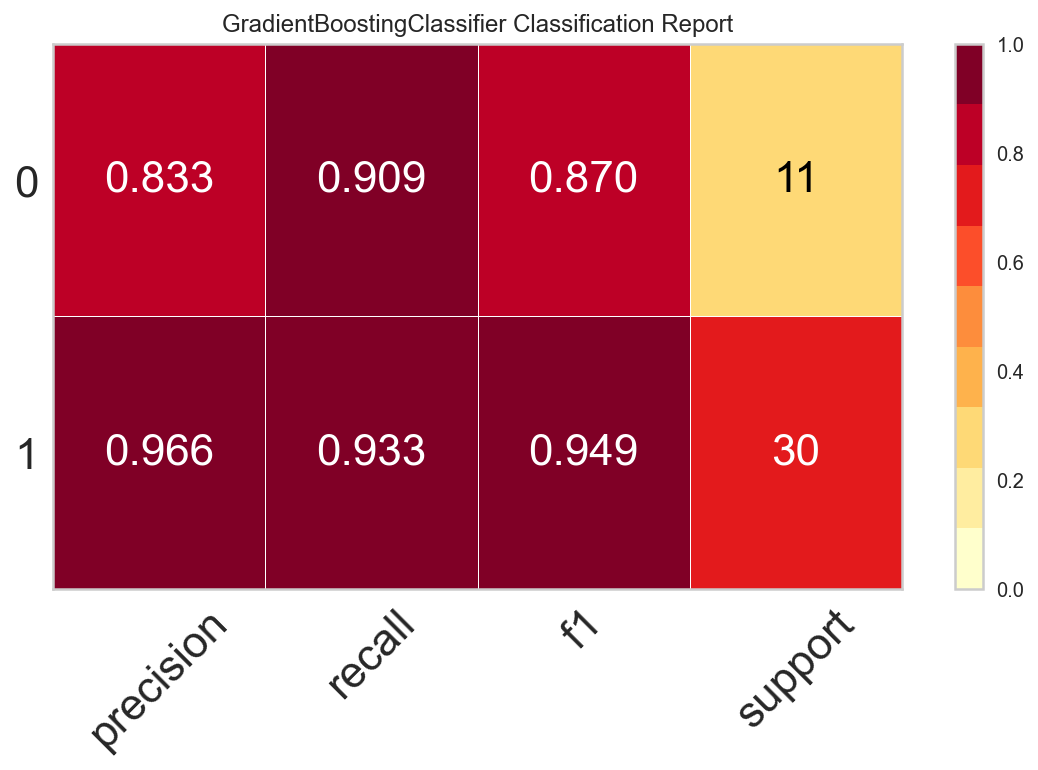

In [91]:
Xtrain, Xtest, ytrain, ytest = train_test_split(prec_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
classes = [1,0]
model=all_model_dict['All Prec']['GB']
visualizer=ClassificationReport(model, classes=classes, support=True)

visualizer.fit(Xtrain, ytrain)        # Fit the visualizer and the model
visualizer.score(Xtest, ytest)        # Evaluate the model on the test data
for label in visualizer.ax.texts:
    label.set_size(22)
visualizer.ax.tick_params(labelsize=22)  # change size of tick labels
visualizer.show(outpath="Fig2C_v2.svg")

In [97]:
plt.clf() 

<Figure size 720x648 with 0 Axes>

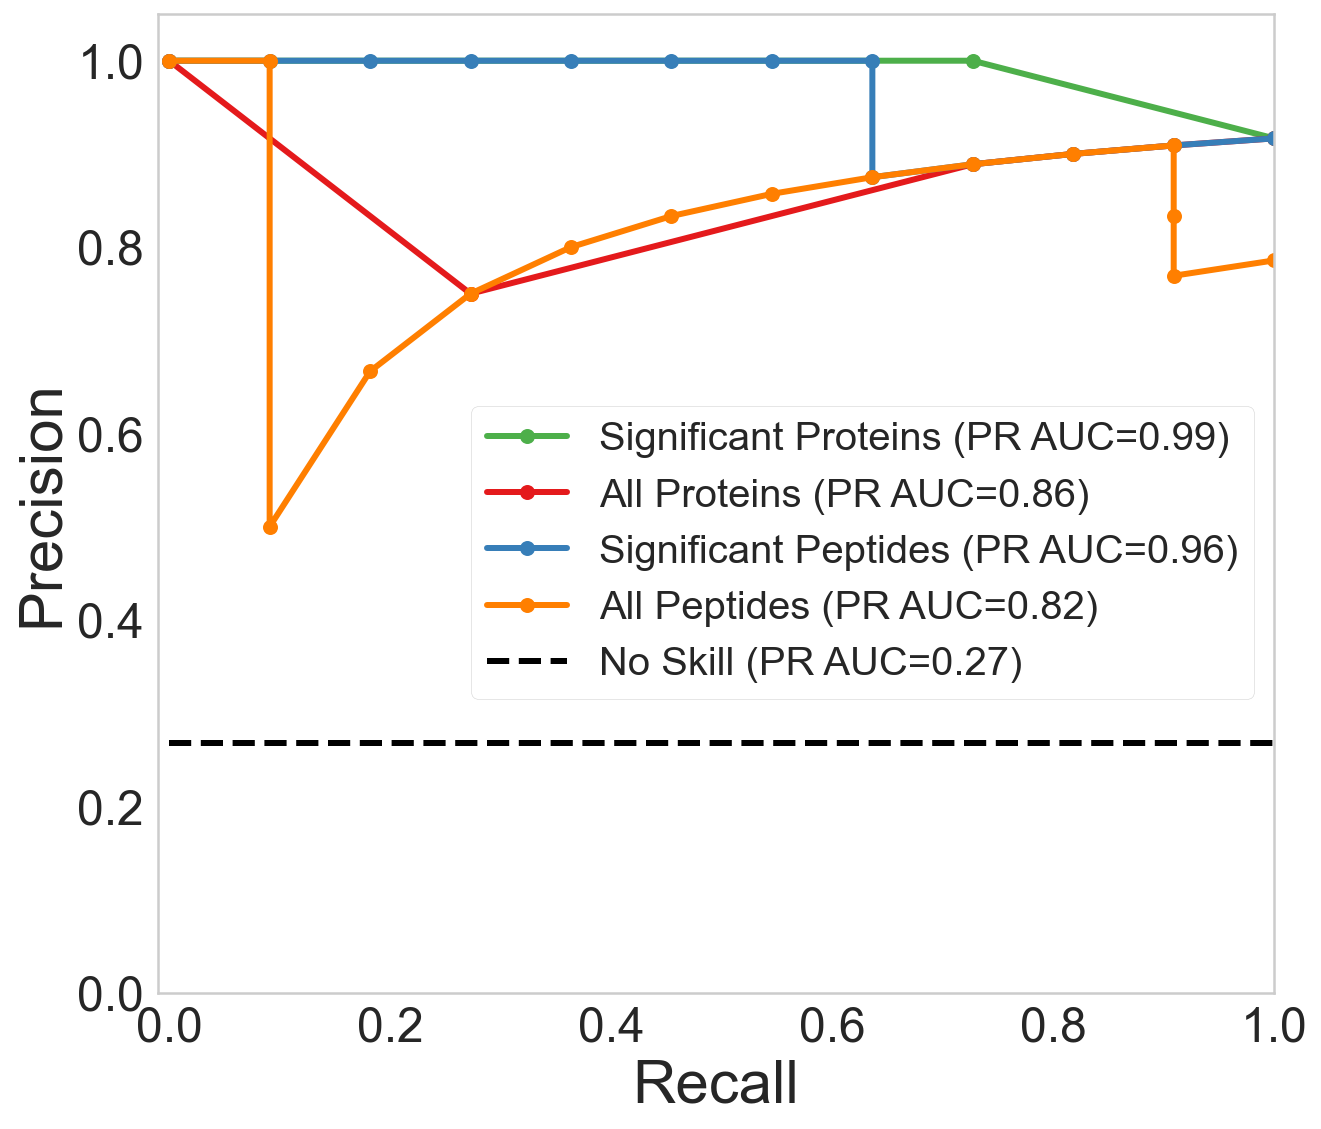

In [103]:
plt.rcParams['figure.figsize']=10,9


#sig prot
model = all_model_dict['Sig Prot']['KNN']
Xtrain, Xtest, ytrain, ytest = train_test_split(sig_prot_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, marker='.', markersize=15, linewidth=3, color='#4daf4a',
            label='Significant Proteins (PR AUC=0.99)')


#all prot
model = all_model_dict['All Prot']['KNN']
Xtrain, Xtest, ytrain, ytest = train_test_split(prot_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, marker='.', markersize=15,linewidth=3, color='#e41a1c',
            label='All Proteins (PR AUC=0.86)')



#sig prec
model = all_model_dict['Sig Prec']['SVC']
Xtrain, Xtest, ytrain, ytest = train_test_split(sig_prec_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, marker='.', markersize=15, linewidth=3, color='#377eb8',
            label='Significant Peptides (PR AUC=0.96)')

#all prec
model = all_model_dict['All Prec']['GB']
Xtrain, Xtest, ytrain, ytest = train_test_split(prec_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, linewidth=3, marker='.', markersize=15,color= '#ff7f00',
            label='All Peptides (PR AUC=0.82)')
#no skill line
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', linewidth=3, color='black',
            label='No Skill (PR AUC=0.27)')

# axis labels
pyplot.xlabel('Recall', fontsize=30)
pyplot.ylabel('Precision', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([-0.01, 1.])
plt.ylim([0.0, 1.05])

pyplot.legend(fontsize=20, loc='center right', bbox_to_anchor=(1, 0.45), frameon=True)
plt.grid(False)
plt.savefig('Fig2A_v2.svg',bbox_inches='tight')
pyplot.show()

### 6. Scatterplot Disease v Control - F1 vs MCC

In [1]:
data = {'MCC': [0,0.809770,0.875758,0.809770,0.941335,0.941335,0.875758,0,0.875758,
               0.941335,0.742818,0.941335,0.941335,0.941335],
        'F1': [0,0.857143,0.909091,0.857143,0.956522,0.956522,0.909091,0,0.909091,0.956522,
              0.800000,0.956522,0.956522,0.956522],
        'Type': ['Significant Peptide','Significant Peptide','Significant Peptide','Significant Peptide','Significant Peptide','Significant Peptide','Significant Peptide',
                'Significant Protein','Significant Protein','Significant Protein','Significant Protein','Significant Protein','Significant Protein','Significant Protein'],
        'Model': ['Dummy','ET','GB', 'RF', 'SVC','KNN', 'LR',
                 'Dummy','ET','GB','RF', 'SVC','KNN', 'LR']}

In [4]:
DvC = pd.DataFrame(data)

In [5]:
DvC

,MCC,F1,Type,Model
0,0.000000,0.000000,Significant Peptide,Dummy
1,0.809770,0.857143,Significant Peptide,ET
2,0.875758,0.909091,Significant Peptide,GB
3,0.809770,0.857143,Significant Peptide,RF
4,0.941335,0.956522,Significant Peptide,SVC
5,0.941335,0.956522,Significant Peptide,KNN
6,0.875758,0.909091,Significant Peptide,LR
7,0.000000,0.000000,Significant Protein,Dummy
8,0.875758,0.909091,Significant Protein,ET
9,0.941335,0.956522,Significant Protein,GB


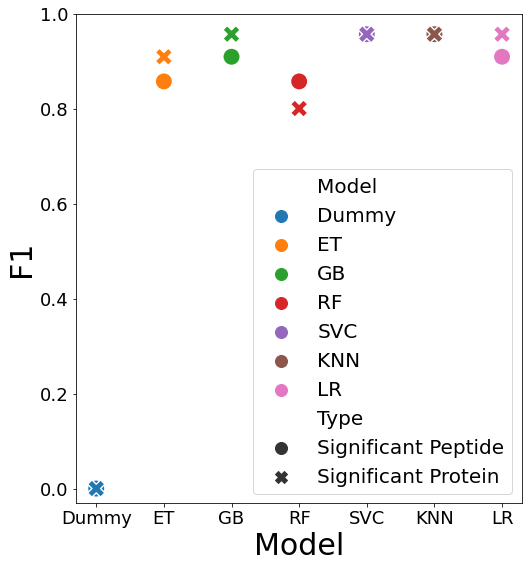

In [6]:
plt.rcParams['figure.figsize']=8,9
ax=sns.scatterplot(data=DvC, x="Model", y="F1", hue="Model", style='Type', s=300)
ax.legend(fontsize=20, bbox_to_anchor=(1, 0.35), loc='center right',markerscale=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1', fontsize=30)
plt.xlabel('Model', fontsize=30)
plt.ylim(-0.03,1)
#ax.set_title("DvC - All Peptides vs All Proteins", fontsize=24)
plt.savefig('Fig2D_v2.svg',bbox_inches='tight')

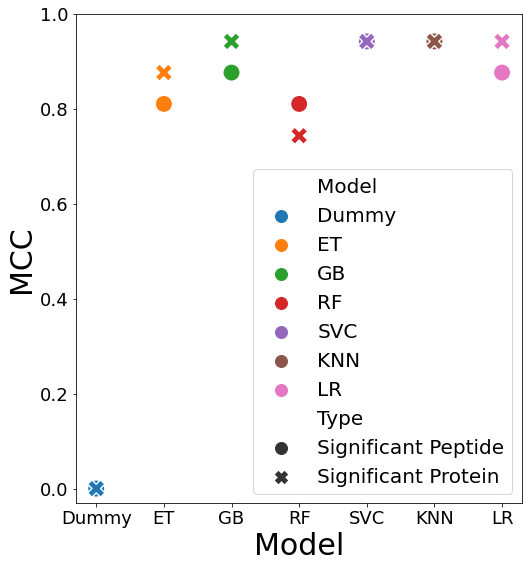

In [7]:
plt.rcParams['figure.figsize']=8,9
ax=sns.scatterplot(data=DvC, x="Model", y="MCC", hue="Model", style='Type', s=300)
ax.legend(fontsize=20, bbox_to_anchor=(1, 0.35), loc='center right',markerscale=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('MCC', fontsize=30)
plt.xlabel('Model', fontsize=30)
plt.ylim(-0.03,1)
#ax.set_title("DvC - All Peptides vs All Proteins", fontsize=24)
plt.savefig('Fig2E_v2.svg',bbox_inches='tight')